# CNN classification model


# **1. Set up**

In [21]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# **2. GPU Checking**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **3. Add parameters & Dataset path**

In [3]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/0/
  inflating: data/0/46304_5.jpg      
  inflating: data/0/46314_8.jpg      
  inflating: data/0/46325_6.jpg      
  inflating: data/0/46326_5.jpg      
  inflating: data/0/46355_3.jpg      
  inflating: data/0/46367_4.jpg      
  inflating: data/0/46368_3.jpg      
  inflating: data/0/46369_8.jpg      
  inflating: data/0/46373_4.jpg      
  inflating: data/0/46378_2.jpg      
  inflating: data/0/46410_2.jpg      
  inflating: data/0/46410_4.jpg      
  inflating: data/0/46454_6.jpg      
  inflating: data/0/46468_4.jpg      
  inflating: data/0/46505_7.jpg      
  inflating: data/0/46512_4.jpg      
  inflating: data/0/46513_2.jpg      
  inflating: data/0/46513_8.jpg      
  inflating: data/0/46514_4.jpg      
  inflating: data/0/46527_8.jpg      
  inflating: data/0/46538_2.jpg      
  inflating: data/0/46549_2.jpg      
  inflating: data/0/46551_5.jpg      
  inflating: data/0/46553_5.jpg      
  inflating: data/0/46565_5.j

In [4]:
BATCH_SIZE = 64
EPOCHS = 10
IMG_SIZE = 28
NUM_CLASSES = 36  # 0-9, A-Z

DATA_DIR = "/content/data"

# **4. Transform & Split Data**

In [5]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [6]:
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# **5. Load Dataset & Label Mapping**

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [11]:
class_names = full_dataset.classes
print("Classes:", class_names)
print("Number of classes:", len(class_names))

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z']
Number of classes: 31


# **6. CNN Model**

In [12]:
class CharCNN(nn.Module):
    def __init__(self, num_classes):
        super(CharCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# **7. Initialize CNN Model, Loss, Optimizer**

In [13]:
model = CharCNN(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# **8. Training Loop**

In [14]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

# Save model
torch.save(model.state_dict(), "char_cnn.pth")

Epoch [1/10], Loss: 3.3714
Epoch [2/10], Loss: 3.0182
Epoch [3/10], Loss: 2.0313
Epoch [4/10], Loss: 0.9490
Epoch [5/10], Loss: 0.4030
Epoch [6/10], Loss: 0.2572
Epoch [7/10], Loss: 0.1863
Epoch [8/10], Loss: 0.1492
Epoch [9/10], Loss: 0.1011
Epoch [10/10], Loss: 0.0807


# **9. Validate**

In [15]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 95.37%


# **10. Predict**

In [16]:
def predict_character(image_path):
    from PIL import Image
    model.eval()
    img = Image.open(image_path).convert('L')
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
    return class_names[pred.item()]

Saving 190715_4.jpg to 190715_4.jpg
Saving 190715_5.jpg to 190715_5.jpg
Saving 190715_6.jpg to 190715_6.jpg
Saving 190715_7.jpg to 190715_7.jpg
Saving 190715_8.jpg to 190715_8.jpg
Saving 190716_0.jpg to 190716_0.jpg
Saving 190716_1.jpg to 190716_1.jpg
Saving 190716_2.jpg to 190716_2.jpg
Saving 190716_3.jpg to 190716_3.jpg
Saving 190716_4.jpg to 190716_4.jpg
Saving 190716_5.jpg to 190716_5.jpg
Saving 190716_6.jpg to 190716_6.jpg
Saving 190716_7.jpg to 190716_7.jpg
Saving 190717_0.jpg to 190717_0.jpg
Saving 190717_1.jpg to 190717_1.jpg
Saving 190717_2.jpg to 190717_2.jpg
Saving 190717_3.jpg to 190717_3.jpg
Saving 190717_4.jpg to 190717_4.jpg
Saving 190717_5.jpg to 190717_5.jpg
Saving 190717_6.jpg to 190717_6.jpg
Saving 190717_7.jpg to 190717_7.jpg
Saving 190717_8.jpg to 190717_8.jpg
Saving 190718_0.jpg to 190718_0.jpg
Saving 190718_1.jpg to 190718_1.jpg
Saving 190718_2.jpg to 190718_2.jpg


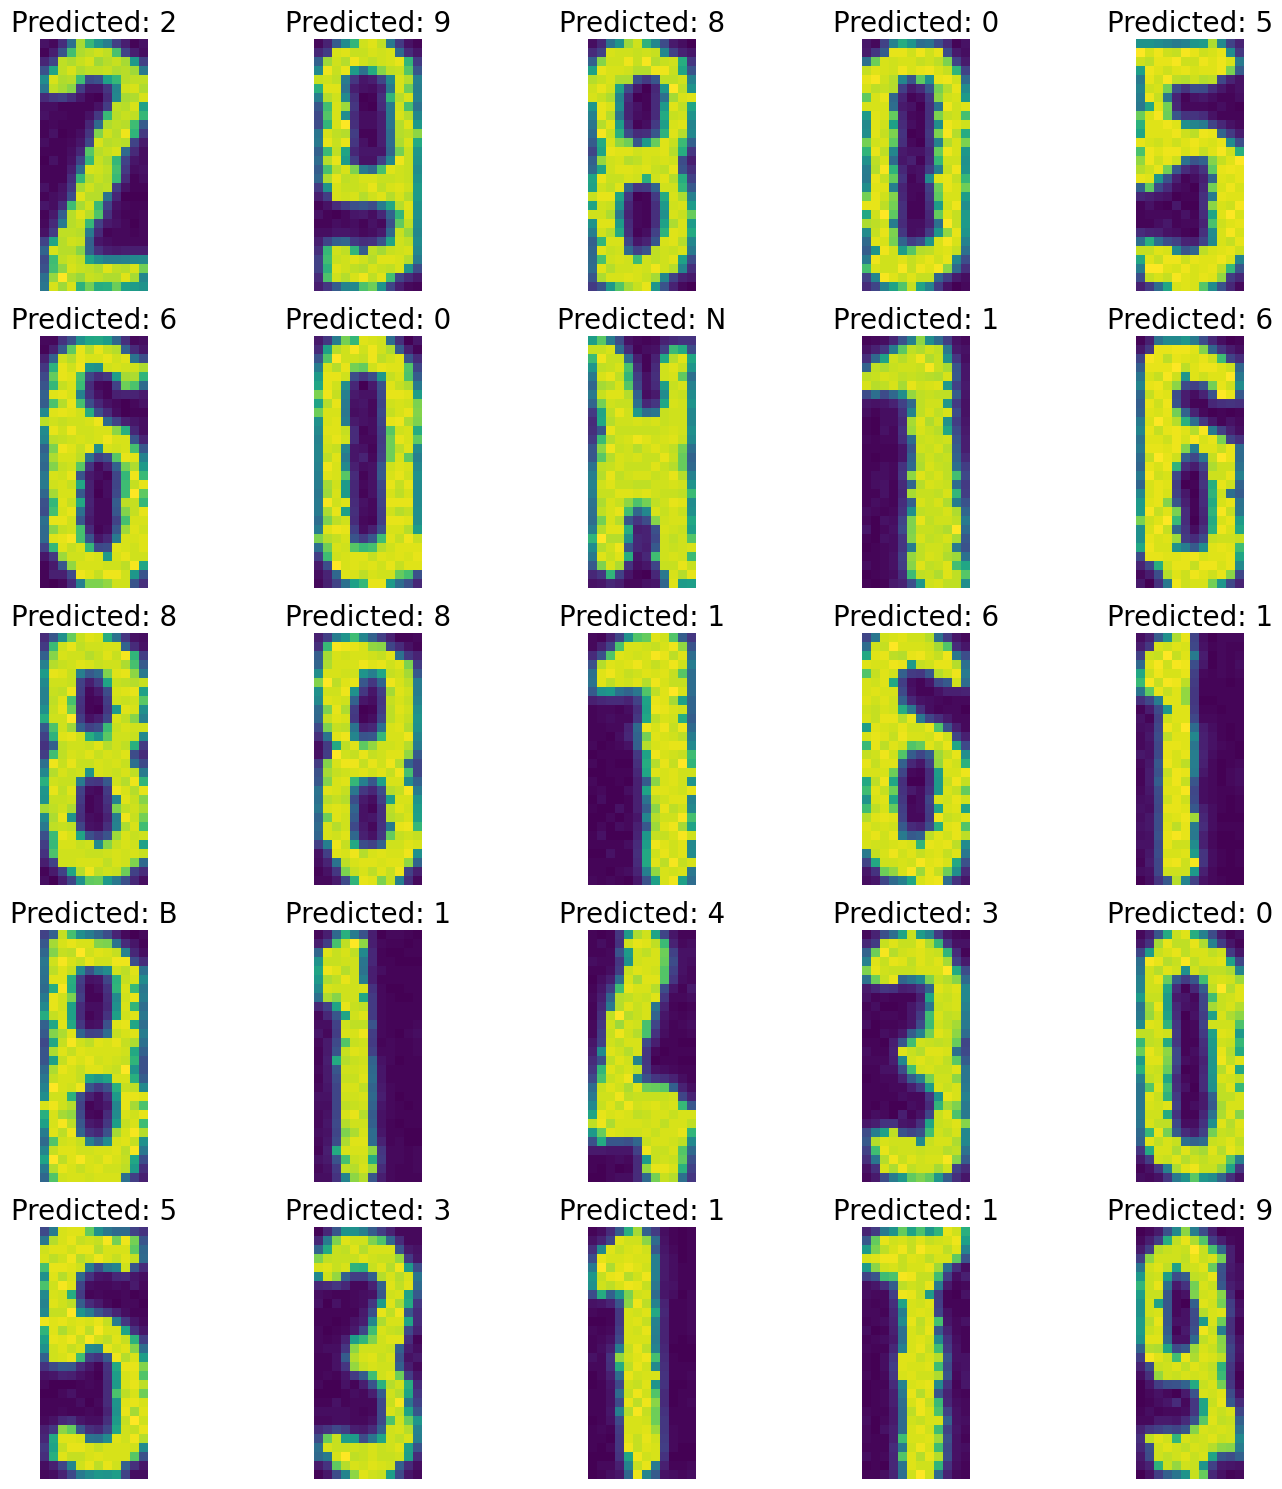

In [29]:
# Upload image(s)
uploaded = files.upload()

# Set grid size (e.g., 5x5)
rows, cols = 5, 5
max_images = rows * cols

# Prepare predictions
images = []
predictions = []

for i, filename in enumerate(uploaded.keys()):
    if i >= max_images:
        print(f"Only displaying first {max_images} images.")
        break
    img = Image.open(filename).convert('L')
    pred = predict_character(filename)
    images.append(img)
    predictions.append(pred)

# Plot in grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for idx in range(rows * cols):
    ax = axes[idx]
    if idx < len(images):
        ax.imshow(images[idx])
        ax.set_title(f"Predicted: {predictions[idx]}", fontsize=20)
    else:
        ax.axis('off')
    ax.axis('off')

plt.tight_layout()
plt.show()
